Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-bawang-merah-malang-2017-2021.csv?token=ARB4LTAYO3V5IH4WDOGVABLAXYS4M \
    -O /tmp/onion.csv

--2021-05-31 14:30:13--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-bawang-merah-malang-2017-2021.csv?token=ARB4LTAYO3V5IH4WDOGVABLAXYS4M
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15960 (16K) [text/plain]
Saving to: ‘/tmp/onion.csv’

/tmp/onion.csv      100%[===================>]  15.59K  --.-KB/s    in 0.001s  

2021-05-31 14:30:14 (11.2 MB/s) - ‘/tmp/onion.csv’ saved [15960/15960]



In [3]:
#Read dataset with pandas, then put it to onion_df variable
onion_df = pd.read_csv('/tmp/onion.csv')
onion_df

tanggal  harga
0    2017-08-02  12000
1    2017-08-03  12000
2    2017-08-04  12000
3    2017-08-07  12000
4    2017-08-08  12000
..          ...    ...
935  2021-05-24  20000
936  2021-05-25  20000
937  2021-05-27  20000
938  2021-05-28  20000
939  2021-05-31  20000

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of onion_df dataframe
onion_df.head()

tanggal  harga
0  2017-08-02  12000
1  2017-08-03  12000
2  2017-08-04  12000
3  2017-08-07  12000
4  2017-08-08  12000

In [5]:
#Inspect the last 5 of onion_df dataframe
onion_df.tail()

tanggal  harga
935  2021-05-24  20000
936  2021-05-25  20000
937  2021-05-27  20000
938  2021-05-28  20000
939  2021-05-31  20000

In [6]:
#Inspect the describtion of onion_df dataframe
onion_df.describe()

harga
count    940.000000
mean   18460.372340
std     6104.561169
min     8000.000000
25%    14000.000000
50%    18000.000000
75%    21500.000000
max    38500.000000

In [7]:
#Casting harga's column to float
onion_df['harga'] = pd.to_numeric(onion_df['harga'], downcast='float')
print(onion_df)
print(onion_df.dtypes)

        tanggal    harga
0    2017-08-02  12000.0
1    2017-08-03  12000.0
2    2017-08-04  12000.0
3    2017-08-07  12000.0
4    2017-08-08  12000.0
..          ...      ...
935  2021-05-24  20000.0
936  2021-05-25  20000.0
937  2021-05-27  20000.0
938  2021-05-28  20000.0
939  2021-05-31  20000.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = onion_df['harga'].max()
onion_df['harga'] /= max

In [9]:
onion_df

tanggal     harga
0    2017-08-02  0.311688
1    2017-08-03  0.311688
2    2017-08-04  0.311688
3    2017-08-07  0.311688
4    2017-08-08  0.311688
..          ...       ...
935  2021-05-24  0.519481
936  2021-05-25  0.519481
937  2021-05-27  0.519481
938  2021-05-28  0.519481
939  2021-05-31  0.519481

[940 rows x 2 columns]

In [10]:
_ = onion_df.hist()

In [11]:
#Get the price and time step from dataframe
temp = onion_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [12]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Onion in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [14]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

In [15]:
len(test_price)

94

Window the Dataset 

In [16]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [17]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [18]:
window_size = 125
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [20]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 32s 106ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 2/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 3/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 4/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 5/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 6/200
2/2 [==============================] - 0s 56ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 7/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 8/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1644 - mean_absolute_error: 0.5453
Epoch 9/200
2/2 [========

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(1e-08, 0.1, 0.0, 0.2)

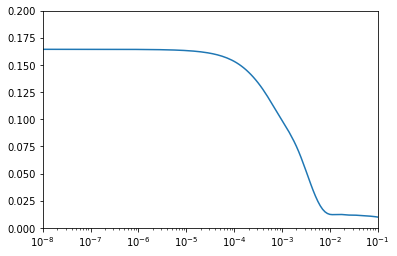

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 0.2])

In [23]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=100, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 0.1019 - mean_absolute_error: 0.4160 - val_loss: 0.0126 - val_mean_absolute_error: 0.1212
Epoch 2/100
2/2 [==============================] - 1s 331ms/step - loss: 0.0185 - mean_absolute_error: 0.1546 - val_loss: 0.0578 - val_mean_absolute_error: 0.3136
Epoch 3/100
2/2 [==============================] - 1s 340ms/step - loss: 0.0546 - mean_absolute_error: 0.3035 - val_loss: 0.0209 - val_mean_absolute_error: 0.1757
Epoch 4/100
2/2 [==============================] - 1s 330ms/step - loss: 0.0172 - mean_absolute_error: 0.1535 - val_loss: 0.0191 - val_mean_absolute_error: 0.1502
Epoch 5/100
2/2 [==============================] - 1s 344ms/step - loss: 0.0230 - mean_absolute_error: 0.1668 - val_loss: 0.0315 - val_mean_absolute_error: 0.2046
Epoch 6/100
2/2 [==============================] - 1s 341ms/step - loss: 0.0289 - mean_

In [24]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


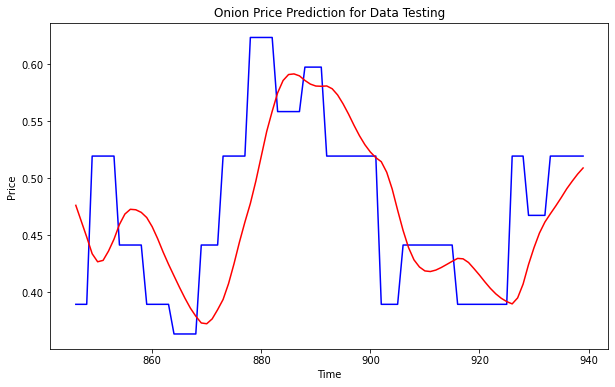

In [25]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Onion Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Onion Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

In [26]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[60:]
epoch_num_zoom = [x+60 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
rnn_forecast

array([0.47631618, 0.46243644, 0.44856963, 0.4339098 , 0.4268885 ,
       0.4280963 , 0.43630362, 0.44665703, 0.45957357, 0.4686951 ,
       0.47285923, 0.47244295, 0.4701437 , 0.4656354 , 0.45761704,
       0.44716516, 0.435467  , 0.424658  , 0.41456503, 0.4045654 ,
       0.3950376 , 0.38632202, 0.37918228, 0.37328583, 0.37258804,
       0.37684968, 0.38492447, 0.39385948, 0.40772605, 0.42508212,
       0.44412863, 0.4616562 , 0.4779646 , 0.49744946, 0.5193172 ,
       0.5410956 , 0.5586489 , 0.5748739 , 0.5856805 , 0.5909053 ,
       0.59145474, 0.58974445, 0.58573675, 0.58253   , 0.5808289 ,
       0.5806234 , 0.58089995, 0.5784555 , 0.57300436, 0.56521887,
       0.55624986, 0.54646647, 0.5373194 , 0.5294296 , 0.52302957,
       0.5181146 , 0.5145461 , 0.5052997 , 0.49062985, 0.47207224,
       0.45433655, 0.43930402, 0.42856163, 0.42230967, 0.41887453,
       0.4183319 , 0.4196029 , 0.4218596 , 0.42453948, 0.42727643,
       0.42984784, 0.42946428, 0.4262394 , 0.42086434, 0.41525

In [28]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [29]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.47633659839630127],
  [0.4590414762496948],
  [0.4502798020839691],
  [0.44285857677459717],
  [0.44224056601524353],
  [0.4445141553878784],
  [0.4469950199127197],
  [0.45479559898376465],
  [0.4672032594680786],
  [0.48262837529182434],
  [0.49382078647613525],
  [0.5019858479499817],
  [0.5062193274497986],
  [0.5077919363975525],
  [0.509101152420044],
  [0.5110901594161987],
  [0.5139081478118896],
  [0.5162174701690674],
  [0.5187466144561768],
  [0.5209532380104065]]]

In [30]:
round(rnn_forecast[-1][-1][0]*max)

20057

In [31]:
model.save("onion_model")

INFO:tensorflow:Assets written to: onion_model/assets


INFO:tensorflow:Assets written to: onion_model/assets


In [32]:
!zip -r onion_model.zip onion_model

  adding: onion_model/ (stored 0%)
  adding: onion_model/assets/ (stored 0%)
  adding: onion_model/keras_metadata.pb (deflated 91%)
  adding: onion_model/saved_model.pb (deflated 90%)
  adding: onion_model/variables/ (stored 0%)
  adding: onion_model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: onion_model/variables/variables.index (deflated 66%)
